# Optimization

In this Notebook we are going to load the Disease model, execute and find the parameters that maximize economic output.

- To load and run the Vensim model we use PySD library, please check the following tutorial before continuing: https://pysd.readthedocs.io/en/master/basic_usage.html#
- Model run's output are Pandas Data Frames, please refer to the Pandas documentation if you need additional insights and supported data operations: https://pandas.pydata.org/pandas-docs/stable/user_guide/index.html#user-guide. 
There is also a 10min tutorial available that might be of your interest: https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html
- We implemented the plots using matplotlib, if you need additional information please refer to the examples in canvas at "Pre-requisites->Computer Installations->Python and useful packages to explore". You may also refer to the following documentation: https://matplotlib.org/stable/contents.html

In [1]:
import pysd
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import scipy as sp

In [2]:
# load the Vensim model into Python
model = pysd.read_vensim(r'C:\Users\dimcp\Documents\MSD-Group-1\SFD_Group.mdl')

In [3]:
# run the model with default parameter values
model_output = model.run()
model_output.head(5)

,FINAL TIME,INITIAL TIME,SAVEPER,TIME STEP,Scaled divorce,Marriage rate,Delay for societal,Divorce,Societal factor,Population,...,Economic factor,Unmarried,K,Marriage,Married,Recovery rate,Divorce rate,Education,W eco,W soc
1992.00,2018,1992,0.25,0.25,340.500009,0.123413,3,6.308103e+07,0.588623,185260000.0,...,0.53333,4.179500e+07,2.2,5.158054e+06,1.132950e+08,0.004,0.556786,0.9,0.649,0.338
1992.25,2018,1992,0.25,0.25,296.979169,0.123413,3,5.501836e+07,0.588623,185260000.0,...,0.53333,4.053566e+07,2.2,5.002634e+06,9.881426e+07,0.004,0.556786,0.9,0.649,0.338
1992.50,2018,1992,0.25,0.25,259.399497,0.123413,3,4.805635e+07,0.588623,185260000.0,...,0.53333,3.931517e+07,2.2,4.852010e+06,8.631032e+07,0.004,0.556786,0.9,0.649,0.338
1992.75,2018,1992,0.25,0.25,226.937609,0.123413,3,4.204246e+07,0.588623,185260000.0,...,0.53333,3.813365e+07,2.2,4.706194e+06,7.550924e+07,0.004,0.556786,0.9,0.649,0.338
1993.00,2018,1992,0.25,0.25,198.968492,0.123205,3,3.686090e+07,0.589316,185260000.0,...,0.53333,3.699093e+07,2.2,4.557469e+06,6.617517e+07,0.004,0.557020,0.9,0.649,0.338


In [4]:
# list all stocks, variables and parameters of the model
list(model_output)

['FINAL TIME',
 'INITIAL TIME',
 'SAVEPER',
 'TIME STEP',
 'Scaled divorce',
 'Marriage rate',
 'Delay for societal',
 'Divorce',
 'Societal factor',
 'Population',
 'Delay for recovery',
 'Recovery',
 'Divorced',
 'Economic factor',
 'Unmarried',
 'K',
 'Marriage',
 'Married',
 'Recovery rate',
 'Divorce rate',
 'Education',
 'W eco',
 'W soc']

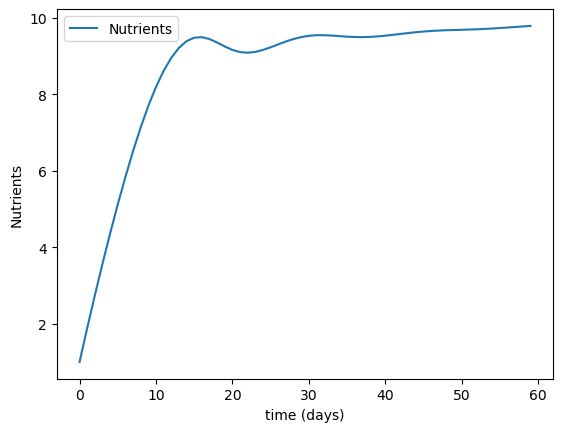

In [622]:
# plot Nutrients for a given Initial Nutrients Value
model_output = model.run(params={'Initial Nutrients': 1},
                         return_timestamps=np.arange(0, 60, 1),
                         return_columns=['Nutrients'])
model_output.plot()
plt.ylabel('Nutrients')
plt.xlabel('time (days)')
plt.show()

In [629]:
# vary the Initial Nutrients and observe its impact on Nutrients
observable1 = 'Nutrients'
parameter1 = 'Initial Nutrients'
parameter1_range = np.arange(0, 10, 0.1)

# lists to store output values
parameter1_values = []
observable_values = []

# go through all values of parameter 1
for parameter1_value in parameter1_range:
    
    # this can be adjusted to achieve more repetitions
    for i in np.arange(0, 3, 1):

        # run the model at the given value for parameter 1
        result = model.run(params={parameter1: parameter1_value}, 
                           return_timestamps=[60],
                           return_columns=[observable1])

        # store results
        parameter1_values.append(parameter1_value)
        observable_values.append(result.loc[60, observable1])


# collect results in a DataFrame
output = pd.DataFrame({parameter1: parameter1_values, observable1: observable_values})

In [627]:
# print the (average) Nutrients for each parameter value
output.groupby(parameter1).mean()

,Bacteria Population
Initial Nutrients,
0.0,9.868654e+08
0.1,9.859826e+08
0.2,9.863057e+08
0.3,9.864907e+08
0.4,9.864548e+08
...,...
9.5,9.875493e+08
9.6,9.875968e+08
9.7,9.877460e+08


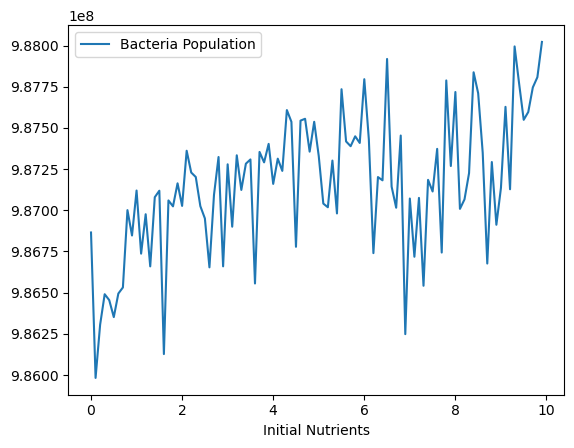

In [628]:
# plot the observable as a function of the parameter values
output.groupby(parameter1).mean().plot()
plt.show()

## Maximising the Value of an Observable

### Optimisation using Two Parameters

In [385]:
observable = 'Divorce'
parameter1 = 'K'
parameter2 = 'W soc'
parameter3 = 'W eco'
parameter4 = 'Delay for societal'
parameter5 = 'Recovery Rate'



def observable_neg(param_list):
    '''
    This function returns the negated value of the observable (possibly 
    averaged over multiple runs) given the values of two parameters in param_list.

    The function is used when maximising the value of the observable using
    the two parameters.
    '''

    # unpack the parameter list
    parameter1_value, parameter2_value = param_list

    # create a list to store the observable values in
    observable_values = []

    # adjust this to change the number of repetitions
    for i in np.arange(0, 10, 1):

        # run the model with the given parameters, returning the info we're interested in
        result = model.run(params={parameter1: parameter1_value,
                                   parameter2: parameter2_value},
                           return_timestamps=[60],
                           return_columns=[observable])

        # store value of observable
        observable_values.append(result.loc[60, observable])

    # return the value to be minimized 
    # (we add a '-' sign because our goal is to maximize)
    return -np.mean(observable_values)

In [386]:
# test the function we created
parameter1_guess = 10
parameter2_guess = 1
observable_neg([parameter1_guess, parameter2_guess])

-995624549.0399052

In [387]:
### find value of parameter 1 that maximises the observable

# we need an initial guess an bounds for both parameters
parameter1_guess = 1
parameter1_bounds = (0, 10)

parameter2_guess = 0.4
parameter2_bounds = (0, 1)

res = sp.optimize.minimize(observable_neg,
                           x0=[parameter1_guess, parameter2_guess],
                           method='L-BFGS-B',
                           bounds=[parameter1_bounds, parameter2_bounds])
res

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -957721101.4935167
        x: [ 1.000e+00  4.000e-01]
      nit: 1
      jac: [-4.150e+12  5.522e+12]
     nfev: 51
     njev: 17
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [15]:
import pysd
import scipy.optimize

<Axes: xlabel='Year'>

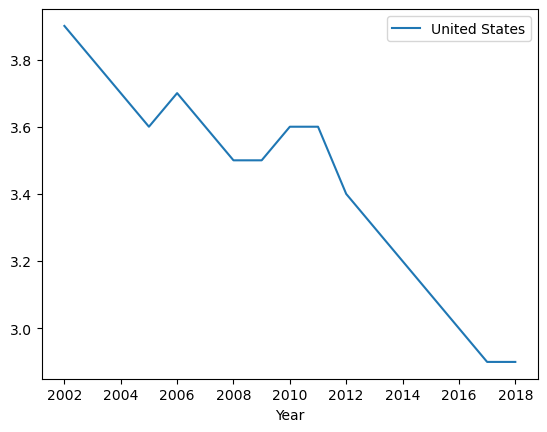

In [22]:
data = pd.read_csv(r'C:\Users\dimcp\Documents\MSD-Group-1\US-Mexico - Copy.csv', sep=',', index_col='Year')
data.plot()

In [5]:
def error(param_list):
    #unpack the parameter list
    parameter1, parameter2, parameter3, parameter4, parameter5 = param_list
    #run the model with the new parameters, returning the info we're interested in
    result = model.run(params={'K':parameter1,
                               'W soc':parameter2,
                               'W eco': parameter3,
                               'Recovery Rate': parameter4,
                               'Delay for societal': parameter5},
                       return_columns=['Divorce', 'Population'],
                       return_timestamps=list(data.index.values))
    #return the sum of the squared errors
    return sum((result['Divorce']/result['Population'] *1000- data['United States'])**2)
cons = [{'type': 'ineq', 'fun': lambda x: parameter2_guess + parameter3_guess - 1}]
    
error([1, 0.3, 0.3, 0.4, 10])

122033.02494226045

In [51]:
parameter1_guess = 1
parameter2_guess = 0.3
parameter3_guess = 0.3
parameter4_guess = 0.4
parameter5_guess = 10

parameter1_bounds = (-4, 4)
parameter2_bounds = (0, 1)
parameter3_bounds = (0,1)
parameter4_bounds = (0,1)
parameter5_bounds = (0,10)

In [56]:
res = scipy.optimize.minimize(error, [parameter1_guess,
                                      parameter2_guess,
                                      parameter3_guess,
                                      parameter4_guess,
                                      parameter5_guess],
                              method='COBYLA',
                              bounds=[parameter1_bounds,
                                      parameter2_bounds,
                                      parameter3_bounds,
                                      parameter4_bounds,
                                      parameter5_bounds],
                              constraints=cons)
res

C:\Users\Coldr\Documents.\SFD_Group.py:158: RuntimeWarning: overflow encountered in exp
  lambda: 1,
C:\Users\Coldr\Documents.\SFD_Group.py:158: RuntimeWarning: divide by zero encountered in double_scalars
  lambda: 1,
C:\Users\Coldr\Documents.\SFD_Group.py:158: RuntimeWarning: overflow encountered in exp
  lambda: 1,
C:\Users\Coldr\Documents.\SFD_Group.py:158: RuntimeWarning: overflow encountered in exp
  lambda: 1,
C:\Users\Coldr\Documents.\SFD_Group.py:158: RuntimeWarning: overflow encountered in exp
  lambda: 1,
C:\Users\Coldr\Documents.\SFD_Group.py:158: RuntimeWarning: overflow encountered in exp
  lambda: 1,
C:\Users\Coldr\Documents.\SFD_Group.py:158: RuntimeWarning: overflow encountered in exp
  lambda: 1,
C:\Users\Coldr\Documents.\SFD_Group.py:158: RuntimeWarning: overflow encountered in exp
  lambda: 1,
C:\Users\Coldr\Documents.\SFD_Group.py:158: RuntimeWarning: overflow encountered in exp
  lambda: 1,
C:\Users\Coldr\Documents.\SFD_Group.py:158: RuntimeWarning: overflow encou

 message: Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
 success: False
  status: 4
     fun: 17409.005997535307
       x: [ 2.139e+00  1.400e+00 -4.000e-01  5.279e-02  1.040e+01]
    nfev: 9
   maxcv: 0.40000000000000036

In [30]:
import scipy.optimize as opt
import warnings
warnings.filterwarnings("ignore")
# Your error function remains the same
def error(param_list):
    #unpack the parameter list
    parameter1, parameter2, parameter3, parameter4, parameter5 = param_list
    #run the model with the new parameters, returning the info we're interested in
    result = model.run(params={'K':parameter1,
                               'W soc':parameter2,
                               'W eco': parameter3,
                               'Recovery Rate': parameter4,
                               'Delay for societal': parameter5},
                       return_columns=['Divorce', 'Population'],
                       return_timestamps=list(data.index.values))#return_timestamps=np.arange(2002, 2018, 1))
    #return the sum of the squared errors
    return sum((result['Divorce']/result['Population'] *1000- data['United States'])**2)

# Define the constraint function
def constraint(param_list):
    return 1 - (param_list[1] + param_list[2])

# Define the constraints dictionary
constraints = [{'type': 'ineq', 'fun': constraint}]

# Initial guesses and bounds remain the same
parameter1_guess = 1
parameter2_guess = 0.33
parameter3_guess = 0.33
parameter4_guess = 0.4
parameter5_guess = 3

parameter1_bounds = (-4, 4)
parameter2_bounds = (0, 1)
parameter3_bounds = (0, 1)
parameter4_bounds = (0, 1)
parameter5_bounds = (0, 10)

# Perform the optimization using SLSQP method
res = opt.minimize(error, [parameter1_guess,
                           parameter2_guess,
                           parameter3_guess,
                           parameter4_guess,
                           parameter5_guess],
                   method='SLSQP',
                   bounds=[parameter1_bounds,
                           parameter2_bounds,
                           parameter3_bounds,
                           parameter4_bounds,
                           parameter5_bounds],
                   constraints=constraints)

# Print the result
print(res)


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.21282317328041087
       x: [ 2.993e+00  3.634e-01  1.134e-17  2.041e-03  4.660e-01]
     nit: 37
     jac: [ 3.732e-03  3.406e-03  3.203e-02 -8.908e-01 -1.537e-04]
    nfev: 242
    njev: 37


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 7.322963089048839
       x: [ 2.226e+00  3.381e-01  6.493e-01  4.225e-03  3.000e+00]
     nit: 12
     jac: [ 9.513e-04  2.027e-06  3.785e-05 -2.719e+00 -1.192e-07]
    nfev: 79
    njev: 12
    

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.21282317328041087
       x: [ 2.993e+00  3.634e-01  1.134e-17  2.041e-03  4.660e-01]
     nit: 37
     jac: [ 3.732e-03  3.406e-03  3.203e-02 -8.908e-01 -1.537e-04]
    nfev: 242
    njev: 37
              Divorce   Population  Scaled divorce
2002.0  734307.991070  185260000.0        3.963662
2003.0  715696.978757  185260000.0        3.863203
2004.0  700294.225330  185260000.0        3.780062
2005.0  686517.935178  185260000.0        3.705700
2006.0  673745.903411  185260000.0        3.636759
2007.0  661714.352762  185260000.0        3.571814
2008.0  650296.589903  185260000.0        3.510183
2009.0  639420.699890  185260000.0        3.451477
2010.0  629038.385290  185260000.0        3.395436
2011.0  619112.777911  185260000.0        3.341859
2012.0  609613.396722  185260000.0        3.290583
2013.0  600513.872249  185260000.0        3.241465
2014.0  591790.793421  185260000.0        3.194380
2015.0  

Text(2, 9000, '')

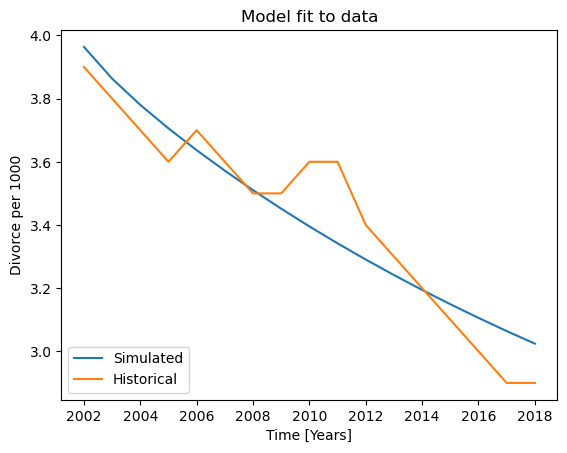

In [39]:
parameter1, parameter2, parameter3, parameter4, parameter5 = res.x
print(res)
result = model.run(params={'K':parameter1,
                           'W soc':parameter2,
                           'W eco':parameter3,
                           'Recovery rate':parameter4,
                           'Delay for societal':parameter5},
                   return_columns=['Divorce','Population','Scaled divorce'],
                   return_timestamps=list(data.index.values))

print(result)

plt.plot(result.index, result['Divorce']/result['Population'] *1000, label='Simulated')
plt.plot(data.index, data['United States'], label='Historical')
plt.xlabel('Time [Years]')
plt.ylabel('Divorce per 1000')
plt.title('Model fit to data')
plt.legend(loc='lower left')
plt.text(2,9000, '', color='r', fontsize=12)

message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.21282317328041087
       x: [ 2.993e+00  3.634e-01  1.134e-17  2.041e-03  4.660e-01]
     nit: 37
     jac: [ 3.732e-03  3.406e-03  3.203e-02 -8.908e-01 -1.537e-04]
    nfev: 242
    njev: 37

In [ ]:
# plots
fig, ax = plt.subplots()
model_output = model.run(params={'Initial Nutrient concentration':5,
                                 'Maximum':1},
                         return_timestamps=np.arange(0, 60, 0.05),
                         return_columns=['Bacteria'])#params={'Initial Nutrient concentration': 2.360679774997897},
ax.plot(model_output,label='Simulated Bacteria')
ax.plot(soildata['time'], soildata['Original Bacteria'],label='Data Bacteria') # marker is optional
plt.title('Bacteria Growth Over Time')
plt.xlabel('Time')
plt.ylabel('Bacteria Count')
ax.legend()
plt.grid(True)
plt.show()

In [35]:
import warnings
warnings.filterwarnings("ignore")
# Initial guesses and bounds remain the same

parameter1_bounds = (-4, 4)
parameter2_bounds = (0, 1)
parameter3_bounds = (0, 1)
parameter4_bounds = (0, 1)
parameter5_bounds = (0, 10)

# Perform the optimization using SLSQP method
res = opt.minimize(error, [parameter1_guess,
                           parameter2_guess,
                           parameter3_guess,
                           parameter4_guess,
                           parameter5_guess],
                   method='SLSQP',
                   bounds=[parameter1_bounds,
                           parameter2_bounds,
                           parameter3_bounds,
                           parameter4_bounds,
                           parameter5_bounds],
                   constraints=constraints)





# Number of steps for each parameter within bounds
steps = 5

# Initialize a list to store optimization results
results = []

# Loop through parameter values
for param1 in np.linspace(parameter1_bounds[0], parameter1_bounds[1], steps):
    for param2 in np.linspace(parameter2_bounds[0], parameter2_bounds[1], steps):
        for param3 in np.linspace(parameter3_bounds[0], parameter3_bounds[1], steps):
            for param4 in np.linspace(parameter4_bounds[0], parameter4_bounds[1], steps):
                for param5 in np.linspace(parameter5_bounds[0], parameter5_bounds[1], steps):
                    # Perform optimization for the current parameter values
                    # Perform the optimization using SLSQP method
                    res = opt.minimize(error, [parameter1_guess,
                                            parameter2_guess,
                                            parameter3_guess,
                                            parameter4_guess,
                                            parameter5_guess],
                                    method='SLSQP',
                                    bounds=[parameter1_bounds,
                                            parameter2_bounds,
                                            parameter3_bounds,
                                            parameter4_bounds,
                                            parameter5_bounds],
                                    constraints=constraints)
                
                    # Store the results in the list
                    results.append((param1, param2,param3,param4,param5, res))
                    print(f"Parameters: {param1}, {param2}, {param3}, {param4}, {param5} - Success: {res.success} - Result: {res.fun} - Optimal Parameters: {res.x}")

# # Display the results
# for param1, param2, res in results:
#     print(f"Parameters: {param1}, {param2} - Success: {res.success} - Result: {res.fun} - Optimal Parameters: {res.x}")



Parameters: -4.0, 0.0, 0.0, 0.0, 0.0 - Success: True - Result: 0.21181918065021932 - Optimal Parameters: [3.00916521e+00 0.00000000e+00 0.00000000e+00 2.03104211e-03
 4.64255084e-01]
Parameters: -4.0, 0.0, 0.0, 0.0, 2.5 - Success: True - Result: 0.21181918065021932 - Optimal Parameters: [3.00916521e+00 0.00000000e+00 0.00000000e+00 2.03104211e-03
 4.64255084e-01]
Parameters: -4.0, 0.0, 0.0, 0.0, 5.0 - Success: True - Result: 0.21181918065021932 - Optimal Parameters: [3.00916521e+00 0.00000000e+00 0.00000000e+00 2.03104211e-03
 4.64255084e-01]
Parameters: -4.0, 0.0, 0.0, 0.0, 7.5 - Success: True - Result: 0.21181918065021932 - Optimal Parameters: [3.00916521e+00 0.00000000e+00 0.00000000e+00 2.03104211e-03
 4.64255084e-01]
Parameters: -4.0, 0.0, 0.0, 0.0, 10.0 - Success: True - Result: 0.21181918065021932 - Optimal Parameters: [3.00916521e+00 0.00000000e+00 0.00000000e+00 2.03104211e-03
 4.64255084e-01]
Parameters: -4.0, 0.0, 0.0, 0.25, 0.0 - Success: True - Result: 0.21181918065021932 

<Axes: xlabel='Year'>

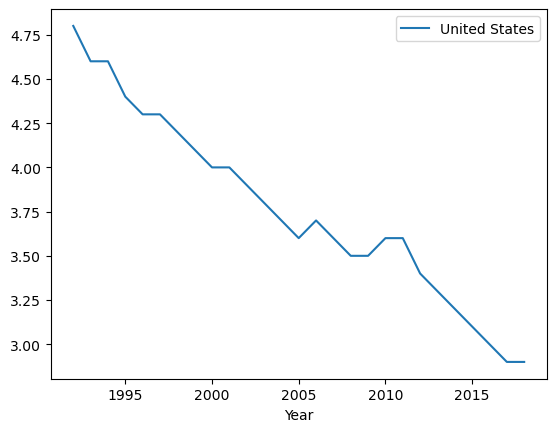

In [15]:
data = pd.read_csv(r'C:\Users\dimcp\Documents\MSD-Group-1\US-Mexico.csv', sep=',', index_col='Year')
data.plot()

In [17]:
import scipy.optimize as opt

# Your error function remains the same
def error(param_list):
    #unpack the parameter list
    parameter1, parameter2, parameter3, parameter4, parameter5 = param_list
    #run the model with the new parameters, returning the info we're interested in
    result = model.run(params={'K':parameter1,
                               'W soc':parameter2,
                               'W eco': parameter3,
                               'Recovery Rate': parameter4,
                               'Delay for societal': parameter5},
                       return_columns=['Divorce', 'Population'],
                       return_timestamps=list(data.index.values))#return_timestamps=np.arange(2002, 2018, 1))
    #return the sum of the squared errors
    return sum((result['Divorce']/result['Population'] *1000- data['United States'])**2)

# Define the constraint function
def constraint(param_list):
    return 1 - (param_list[1] + param_list[2])

# Define the constraints dictionary
constraints = [{'type': 'ineq', 'fun': constraint}]

# Initial guesses and bounds remain the same
parameter1_guess = 1
parameter2_guess = 0.6
parameter3_guess = 0.2
parameter4_guess = 0.4
parameter5_guess = 3

parameter1_bounds = (-4, 4)
parameter2_bounds = (0, 1)
parameter3_bounds = (0, 1)
parameter4_bounds = (0, 1)
parameter5_bounds = (0, 10)

# Perform the optimization using SLSQP method
res = opt.minimize(error, [parameter1_guess,
                           parameter2_guess,
                           parameter3_guess,
                           parameter4_guess,
                           parameter5_guess],
                   method='SLSQP',
                   bounds=[parameter1_bounds,
                           parameter2_bounds,
                           parameter3_bounds,
                           parameter4_bounds,
                           parameter5_bounds],
                   constraints=constraints)

# Print the result
print(res)


c:\Users\dimcp\Anaconda3\lib\site-packages\pysd\py_backend\statefuls.py:507: RuntimeWarning: invalid value encountered in divide
  return (targets - self.state) * self.order / self.smooth_time_func()
c:\Users\dimcp\Anaconda3\lib\site-packages\pysd\py_backend\statefuls.py:507: RuntimeWarning: invalid value encountered in divide
  return (targets - self.state) * self.order / self.smooth_time_func()
c:\Users\dimcp\Anaconda3\lib\site-packages\pysd\py_backend\statefuls.py:507: RuntimeWarning: invalid value encountered in divide
  return (targets - self.state) * self.order / self.smooth_time_func()
C:\Users\dimcp\Documents\MSD-Group-1\SFD_Group.py:282: RuntimeWarning: overflow encountered in double_scalars
  return marriage_rate() * unmarried()
C:\Users\dimcp\Documents\MSD-Group-1\SFD_Group.py:183: RuntimeWarning: invalid value encountered in double_scalars
  return unmarried() + married() + divorced()
C:\Users\dimcp\Documents\MSD-Group-1\SFD_Group.py:299: RuntimeWarning: invalid value encou

 message: Positive directional derivative for linesearch
 success: False
  status: 8
     fun: 93360.59933233711
       x: [ 4.000e+00  4.926e-03  9.978e-01  5.489e-03  2.239e+00]
     nit: 12
     jac: [-2.066e+03 -5.821e+04 -7.973e+04  2.398e+04  1.549e+03]
    nfev: 61
    njev: 8


 message: Positive directional derivative for linesearch
 success: False
  status: 8
     fun: 93360.59933233711
       x: [ 4.000e+00  4.926e-03  9.978e-01  5.489e-03  2.239e+00]
     nit: 12
     jac: [-2.066e+03 -5.821e+04 -7.973e+04  2.398e+04  1.549e+03]
    nfev: 61
    njev: 8


Text(2, 9000, '')

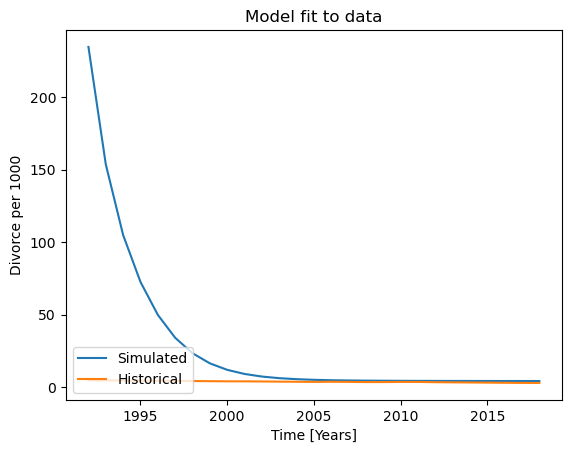

In [18]:
parameter1, parameter2, parameter3, parameter4, parameter5 = res.x
print(res)
result = model.run(params={'K':parameter1,
                           'W soc':parameter2,
                           'W eco':parameter3,
                           'Recovery rate':parameter4,
                           'Delay for societal':parameter5},
                   return_columns=['Divorce','Population'],
                   return_timestamps=list(data.index.values))

# print(result)

plt.plot(result.index, result['Divorce']/result['Population'] *1000, label='Simulated')
plt.plot(data.index, data['United States'], label='Historical')
plt.xlabel('Time [Years]')
plt.ylabel('Divorce per 1000')
plt.title('Model fit to data')
plt.legend(loc='lower left')
plt.text(2,9000, '', color='r', fontsize=12)

### Optimisation Using a Single Parameter

In [672]:
observable = 'Bacteria Population'
parameter1 = 'Nutrients Injected to soil'

def observable_neg(parameter1_value):
    '''
    This function returns the negated value of the observable (possibly 
    averaged over multiple runs) given the value of the parameter in param_list.
    This is the same function as above, but now adjusted to work with only one
    parameter.

    The function is used when maximising the value of the observable using
    the single parameter.
    '''

    # create a list to store the observable values in
    observable_values = []

    # adjust this to change the number of repetitions
    for i in np.arange(0, 1, 1):

        # run the model with the given parameter value, returning the info we're interested in
        result = model.run(params={parameter1: parameter1_value},
                           return_timestamps=[60],
                           return_columns=[observable])

        # store value of observable
        observable_values.append(result.loc[60, observable])

    # return the value to be minimized 
    # (we add a '-' sign because our goal is to maximize)
    return -np.mean(observable_values)

In [752]:
# test the function we created
parameter1_guess = 0.3

observable_neg(parameter1_guess)

-609657025.896136

In [712]:
### find value of parameter 1 that maximises the observable

# for 1d minimisation we don't need an initial guess, just bounds
parameter1_bounds = (0, 1)
res = sp.optimize.minimize_scalar(observable_neg, 
                                  method='bounded', 
                                  bounds=parameter1_bounds)
print(observable_values)
res

[12.791142411024671, 12.769964938364197, 12.787634297344677, 10.408048317654794, 10.490801741747404, 10.672743008211764, 9.90127995199902, 10.258554953572322, 10.237603151372053, 9.941985608422078, 10.171948451232907, 10.063685541408889, 10.053616628380965, 9.678667322746543, 9.834701231815224, 10.03920644270341, 9.816592556020703, 9.604011248836546, 10.307748645946575, 10.095121102908232, 10.287948043015804, 10.152335171132828, 10.32505331472056, 10.031310869429108, 9.553504947877261, 10.130126485434815, 10.124563379055246, 10.014158645642375, 9.4936331836171, 10.002737299980582, 10.567780113950995, 10.057489213271978, 10.019147493225741, 10.209198420795264, 10.074372927034865, 10.02203300723799, 10.08418002048427, 10.080439205567403, 10.373030994103734, 10.008588055172867, 10.663607002623827, 9.918849615169432, 10.184939754735444, 10.462593672771034, 10.509765518898824, 10.913971124902426, 10.178060052360589, 10.290945796643879, 10.248069294554929, 11.000448858181676, 10.642221508386

 message: Solution found.
 success: True
  status: 0
     fun: -988359745.6901844
       x: 0.8107602808472184
     nit: 25
    nfev: 25

,Nutrients
Nutrients Injected to soil,
0.0,12.782914
0.1,10.523864
0.2,10.132479
0.3,10.059207
0.4,9.855662
...,...
9.5,18.224623
9.6,18.306313
9.7,18.384202
